# HW 4: MLE/MAP

## Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)
Consider the theory and the notation provided in the the MLE/MAP section (https://devangelista2.github.io/statistical-mathematical-methods/regression_classification/MLE_MAP.html). Let $f_\theta(x)$ be a polynomial regression model as in the previous Homework, and let the `poly_regression_small.csv` from Virtuale be the training set. Then, sample 20% of the data in the `poly_regression_large.csv` dataset to use as test set.

* For a given value of $K$, write three Python functions computing $\theta_{MLE}$, i.e. the optimal parameters obtained by optimizing the MLE-related loss function with Gaussian assumption on the likelihood $p_\theta(y | x)$, by Gradient Descent, Stochastic Gradient Descent (with a `batch_size` = 5), and Normal Equations method with Cholesky Decomposition.
* Compare the performance of the three regression model computed above. In particular, if $(X_{test}, Y_{test})$ is the test set from the `poly_regression_large.csv` dataset, for each of the model, compute:

  $$
  Err = \frac{1}{N_{test}} \sum_{i=1}^{N_{test}} (f_\theta(x^i) - y^i)^2,
  $$

  where $N_{test}$ is the number of elements in the test set, $(x^i, y^i)$ are the input and output elements in the test set. Comment the performance of the three models. 
* For different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the three learned regression model $f_\theta(x)$. Comment the results.
* For increasing values of $K$, compute the training and test error as discussed above. Plot the two errors with respect to $K$. Comment the results.
* Repeat the same experiments by considering the MAP formulation with Gaussian assumption on the prior term $p(\theta)$. Set $K = 8$ and test different values of $\lambda > 0$ in the experiments. Comment the results, comparing:
  - the three optimization method used to obtain $\theta_{MAP}$ (i.e. GD, SGD and Normal Equations),
  - the different values of $\lambda > 0$ tested,
  - the results obtained by $\theta_{MLE}$ vs $\theta_{MAP}$.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load datasets
small_data = pd.read_csv("poly_regression_small.csv").dropna()
large_data = pd.read_csv("poly_regression_large.csv").dropna()

# Split the large dataset: 80% for training, 20% for testing
train_data, test_data = train_test_split(large_data, test_size=0.2, random_state=42)

# Print sizes of the datasets
print(f"Small dataset size: {small_data.shape}")
print(f"Large dataset size: {large_data.shape}")
print(f"Train dataset size: {train_data.shape}")
print(f"Test dataset size: {test_data.shape}")


Small dataset size: (50, 3)
Large dataset size: (1000, 3)
Train dataset size: (800, 3)
Test dataset size: (200, 3)


In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Preprocessing
def prepare_polynomial_features(x, degree):
    return np.vander(x, degree + 1, increasing=True)

def compute_error(X, Y, theta):
    preds = X @ theta
    return np.mean((preds - Y) ** 2)

# Compute R-squared
def compute_r_squared(X, Y, theta):
    preds = X @ theta
    ss_total = np.sum((Y - np.mean(Y)) ** 2)
    ss_residual = np.sum((Y - preds) ** 2)
    return 1 - (ss_residual / ss_total)

# 1. Gradient Descent
def gradient_descent(X, Y, degree, lr=0.01, epochs=1000):
    theta = np.zeros(degree + 1)
    m = len(Y)
    for _ in range(epochs):
        gradients = (1 / m) * X.T @ (X @ theta - Y)
        theta -= lr * gradients
    return theta

# 2. Stochastic Gradient Descent
def stochastic_gradient_descent(X, Y, degree, lr=0.01, epochs=1000, batch_size=5):
    theta = np.zeros(degree + 1)
    m = len(Y)
    for _ in range(epochs):
        indices = np.random.permutation(m)
        X = X[indices]
        Y = Y[indices]
        for i in range(0, m, batch_size):
            X_batch = X[i:i + batch_size]
            Y_batch = Y[i:i + batch_size]
            gradients = (1 / batch_size) * X_batch.T @ (X_batch @ theta - Y_batch)
            theta -= lr * gradients
    return theta

# 3. Normal Equations with Cholesky
def normal_equations(X, Y):
    XT_X = X.T @ X
    XT_Y = X.T @ Y
    L = np.linalg.cholesky(XT_X)
    return np.linalg.solve(L.T, np.linalg.solve(L, XT_Y))

# Train and Test
def train_and_evaluate(degree, lr=0.01, epochs=100, batch_size=5):
    # Training Data
    X_train = prepare_polynomial_features(train_data['x'].values, degree)
    Y_train = train_data['y'].values

    # Test Data
    X_test = prepare_polynomial_features(test_data['x'].values, degree)
    Y_test = test_data['y'].values

    # Train Models
    theta_gd = gradient_descent(X_train, Y_train, degree, lr, epochs)
    theta_sgd = stochastic_gradient_descent(X_train, Y_train, degree, lr, epochs, batch_size)
    theta_ne = normal_equations(X_train, Y_train)

    # Compute Errors
    err_gd = compute_error(X_test, Y_test, theta_gd)
    err_sgd = compute_error(X_test, Y_test, theta_sgd)
    err_ne = compute_error(X_test, Y_test, theta_ne)
    # Compute R-squared
    r2_gd = compute_r_squared(X_test, Y_test, theta_gd)
    r2_sgd = compute_r_squared(X_test, Y_test, theta_sgd)
    r2_ne = compute_r_squared(X_test, Y_test, theta_ne)
    # Summary DataFrame
    results = pd.DataFrame({
        'Method': ['Gradient Descent', 'Stochastic Gradient Descent', 'Normal Equations'],
        'Error': [err_gd, err_sgd, err_ne],
        'R-Squared': [r2_gd, r2_sgd, r2_ne]
    })

    return theta_gd, theta_sgd, theta_ne, results

# Visualization
def plot_results(degree, theta_gd, theta_sgd, theta_ne):
    X_train = prepare_polynomial_features(train_data['x'].values, degree)
    Y_train = train_data['y'].values

    X_test = prepare_polynomial_features(test_data['x'].values, degree)
    Y_test = test_data['y'].values

    X_plot = np.linspace(min(train_data['x'].min(), test_data['x'].min()), 
                         max(train_data['x'].max(), test_data['x'].max()), 500)
    X_plot_poly = prepare_polynomial_features(X_plot, degree)

    plt.scatter(train_data['x'], train_data['y'], color='blue', label='Training Data')
    plt.scatter(test_data['x'], test_data['y'], color='orange', label='Test Data')
    plt.plot(X_plot, X_plot_poly @ theta_gd, color='red', label='GD Model')
    plt.plot(X_plot, X_plot_poly @ theta_sgd, color='green', label='SGD Model')
    plt.plot(X_plot, X_plot_poly @ theta_ne, color='purple', label='Normal Eq Model')
    plt.legend()
    plt.title(f"Degree {degree} Polynomial Regression")
    plt.show()

# Error vs Degree Plot
def  plot_errors(max_degree):
    train_errors = []
    test_errors = []
    for degree in range(1, max_degree + 1):
        theta_gd, theta_sgd, theta_ne, results = train_and_evaluate(degree)
        train_errors.append(compute_error(prepare_polynomial_features(train_data['x'], degree),
                                          train_data['y'], theta_gd))
        test_errors.append(results['Error'][0])  # Assuming GD's performance
    plt.plot(range(1, max_degree + 1), train_errors, label='Training Error', color='blue')
    plt.plot(range(1, max_degree + 1), test_errors, label='Test Error', color='orange')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Error')
    plt.title('Error vs Polynomial Degree')
    plt.legend()
    plt.show()


Degree: 1, GD Error: 0.1956811747843387, SGD Error: 0.03275741743041935, Normal Eq Error: 0.03270686728993093


/var/folders/nd/0cfyb2fn46s7tqfdlzncgshm0000gp/T/ipykernel_17938/3851859939.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([all_results, results], ignore_index=True)


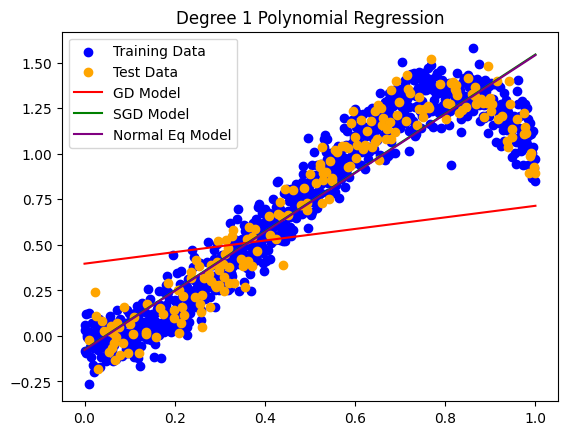

Degree: 2, GD Error: 0.14835933238881432, SGD Error: 0.03387058596598202, Normal Eq Error: 0.02267198971132151


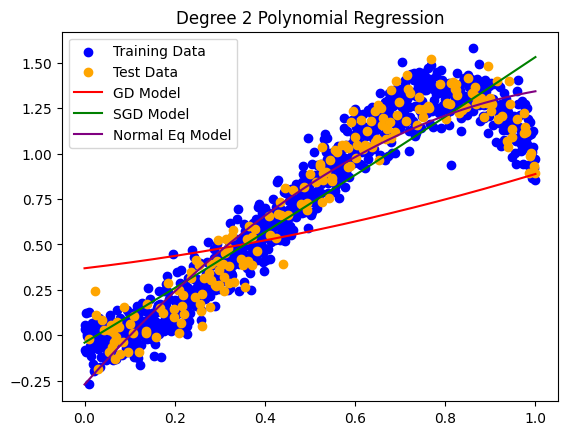

Degree: 3, GD Error: 0.1280136718785207, SGD Error: 0.02389868741582328, Normal Eq Error: 0.009340850152919277


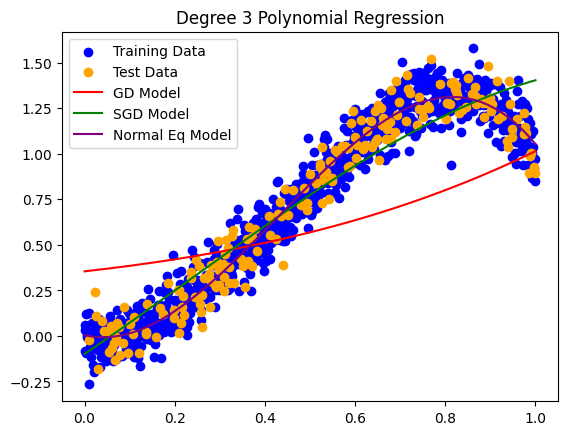

Degree: 4, GD Error: 0.11919471876057183, SGD Error: 0.01615729187865709, Normal Eq Error: 0.009079184533324531


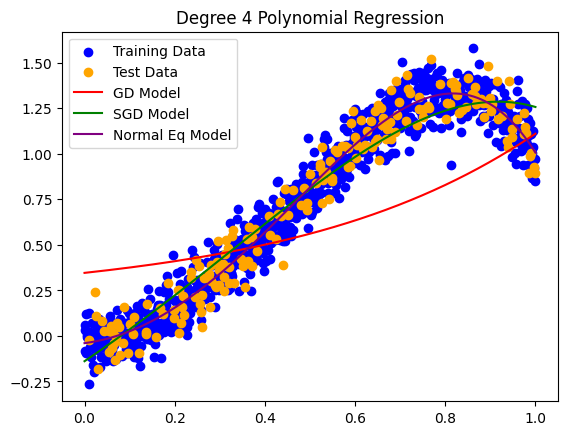

Degree: 5, GD Error: 0.1156571681690258, SGD Error: 0.01220705095180039, Normal Eq Error: 0.009031711491351102


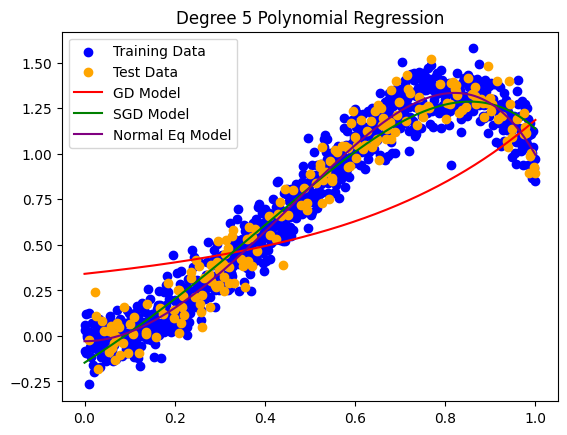

Degree: 6, GD Error: 0.11463711126642943, SGD Error: 0.010507832930642703, Normal Eq Error: 0.009085996186351742


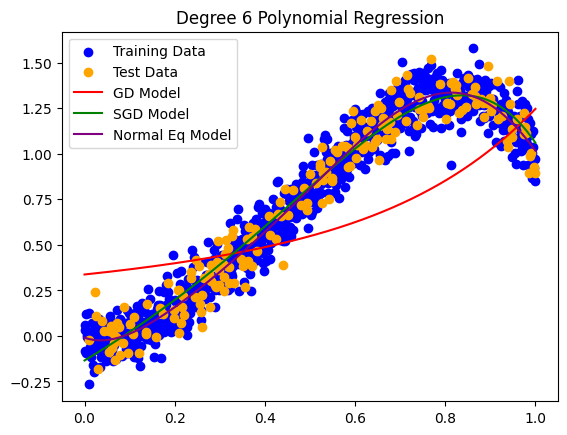

   Degree                       Method     Error  R-Squared
0       1             Gradient Descent  0.195681   0.171348
1       1  Stochastic Gradient Descent  0.032757   0.861282
2       1             Normal Equations  0.032707   0.861496
3       2             Gradient Descent  0.148359   0.371742
4       2  Stochastic Gradient Descent  0.033871   0.856568
5       2             Normal Equations  0.022672   0.903991
6       3             Gradient Descent  0.128014   0.457900
7       3  Stochastic Gradient Descent  0.023899   0.898796
8       3             Normal Equations  0.009341   0.960444
9       4             Gradient Descent  0.119195   0.495246
10      4  Stochastic Gradient Descent  0.016157   0.931579
11      4             Normal Equations  0.009079   0.961552
12      5             Gradient Descent  0.115657   0.510226
13      5  Stochastic Gradient Descent  0.012207   0.948307
14      5             Normal Equations  0.009032   0.961753
15      6             Gradient Descent  

In [3]:
all_results = pd.DataFrame(columns=['Degree', 'Method', 'Error', 'R-Squared'])

for degree in range(1, 7):
    theta_gd, theta_sgd, theta_ne, results = train_and_evaluate(degree)
    results['Degree'] = degree
    all_results = pd.concat([all_results, results], ignore_index=True)
    print(f"Degree: {degree}, GD Error: {results['Error'][0]}, SGD Error: {results['Error'][1]}, Normal Eq Error: {results['Error'][2]}")
    plot_results(degree, theta_gd, theta_sgd, theta_ne)

print(all_results)

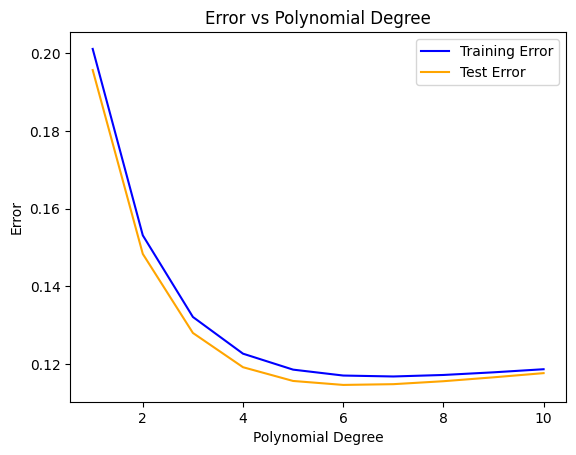

In [4]:
plot_errors(10)

## Introducing MAP
prior term into the optimization process. In the MAP estimation under Gaussian assumptions, the prior is 

$$
p(\theta) \propto \exp\left(-\frac{\lambda}{2} \|\theta\|^2\right)
$$

leading to a regularization term in the cost function. The MAP cost function becomes:

$$
J(\theta) = \frac{1}{2m} \|X\theta - Y\|^2 + \frac{\lambda}{2} \|\theta\|^2
$$


Gradient descent and SGD must be implemented with MAP, so as the cholesky decomposition

In [5]:
def gradient_descent_map(X, Y, degree, lr=0.01, epochs=1000, lambda_=1.0):
    theta = np.zeros(degree + 1)
    m = len(Y)
    for _ in range(epochs):
        gradients = (1 / m) * X.T @ (X @ theta - Y) + lambda_ * theta
        theta -= lr * gradients
    return theta
def stochastic_gradient_descent_map(X, Y, degree, lr=0.01, epochs=1000, batch_size=5, lambda_=1.0):
    theta = np.zeros(degree + 1)
    m = len(Y)
    for _ in range(epochs):
        indices = np.random.permutation(m)
        X = X[indices]
        Y = Y[indices]
        for i in range(0, m, batch_size):
            X_batch = X[i:i + batch_size]
            Y_batch = Y[i:i + batch_size]
            gradients = (1 / batch_size) * X_batch.T @ (X_batch @ theta - Y_batch) + lambda_ * theta
            theta -= lr * gradients
    return theta
def normal_equations_map(X, Y, lambda_=1.0):
    XT_X = X.T @ X + lambda_ * np.eye(X.shape[1])
    XT_Y = X.T @ Y
    L = np.linalg.cholesky(XT_X)
    return np.linalg.solve(L.T, np.linalg.solve(L, XT_Y))

In [6]:
def train_and_evaluate_map(degree, lr=0.01, epochs=100, batch_size=5, lambda_=1.0):
    # Training Data
    X_train = prepare_polynomial_features(train_data['x'].values, degree)
    Y_train = train_data['y'].values

    # Test Data
    X_test = prepare_polynomial_features(test_data['x'].values, degree)
    Y_test = test_data['y'].values

    # Train Models
    theta_gd_map = gradient_descent_map(X_train, Y_train, degree, lr, epochs, lambda_)
    theta_sgd_map = stochastic_gradient_descent_map(X_train, Y_train, degree, lr, epochs, batch_size, lambda_)
    theta_ne_map = normal_equations_map(X_train, Y_train, lambda_)

    # Compute Errors
    err_gd_map = compute_error(X_test, Y_test, theta_gd_map)
    err_sgd_map = compute_error(X_test, Y_test, theta_sgd_map)
    err_ne_map = compute_error(X_test, Y_test, theta_ne_map)
    # Compute R-squared
    r2_gd = compute_r_squared(X_test, Y_test, theta_gd_map)
    r2_sgd = compute_r_squared(X_test, Y_test, theta_sgd_map)
    r2_ne = compute_r_squared(X_test, Y_test, theta_ne_map)
    # Summary DataFrame
    results = pd.DataFrame({
        'Method': ['Gradient Descent MAP', 'Stochastic Gradient Descent MAP', 'Normal Equations MAP'],
        'Error': [err_gd_map, err_sgd_map, err_ne_map],
        'R-Squared': [r2_gd, r2_sgd, r2_ne]
    })

    return theta_gd_map, theta_sgd_map, theta_ne_map, results


In [7]:
def plot_results_map(degree, theta_gd_map, theta_sgd_map, theta_ne_map, lambda_):

    X_plot = np.linspace(min(train_data['x'].min(), test_data['x'].min()), 
                         max(train_data['x'].max(), test_data['x'].max()), 500)
    X_plot_poly = prepare_polynomial_features(X_plot, degree)

    plt.scatter(train_data['x'], train_data['y'], color='blue', label='Training Data')
    plt.scatter(test_data['x'], test_data['y'], color='orange', label='Test Data')
    plt.plot(X_plot, X_plot_poly @ theta_gd_map, color='red', label='GD Model MAP')
    plt.plot(X_plot, X_plot_poly @ theta_sgd_map, color='green', label='SGD Model MAP')
    plt.plot(X_plot, X_plot_poly @ theta_ne_map, color='purple', label='Normal Eq Model MAP')
    plt.legend()
    plt.title(f"Degree {degree} Polynomial Regression with MAP (lambda={lambda_})")
    plt.show()

Lambdas bigger than one make the approximation poor and for the GD like it becomes a straight line

Degree: 1, Lambda: 0.01, GD Error: 0.1967672428511113, SGD Error: 0.03390987237727249, Normal Eq Error: 0.03270513267549648


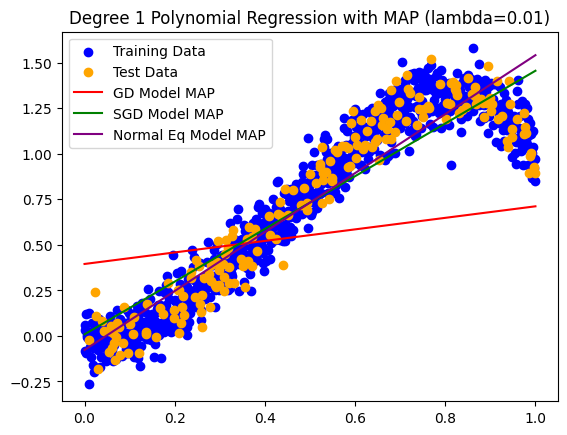

Degree: 1, Lambda: 0.1, GD Error: 0.20668636264015908, SGD Error: 0.08038797293454227, Normal Eq Error: 0.03268999742305932


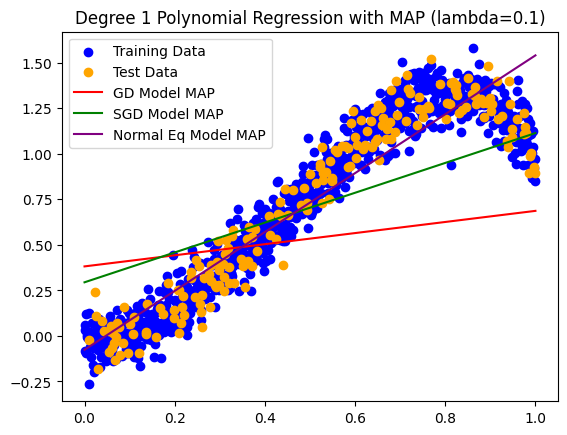

Degree: 2, Lambda: 0.01, GD Error: 0.1493846479593917, SGD Error: 0.039435791560763864, Normal Eq Error: 0.022689206534714512


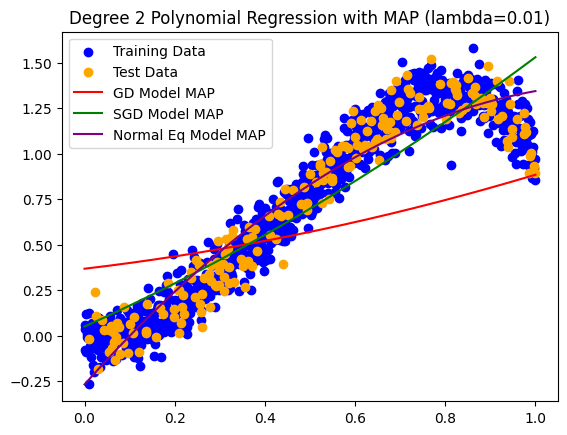

Degree: 2, Lambda: 0.1, GD Error: 0.15882650524419265, SGD Error: 0.06163346327005742, Normal Eq Error: 0.022873320672362876


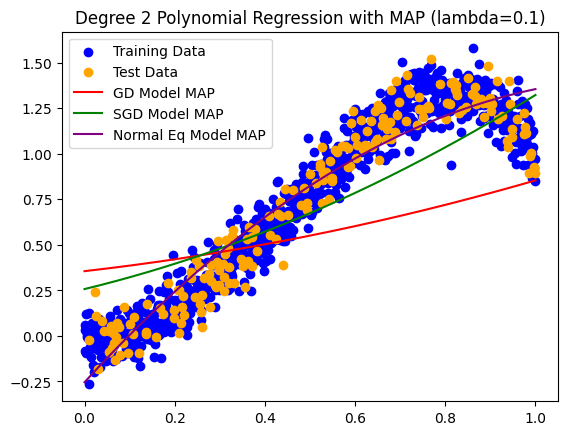

Degree: 3, Lambda: 0.01, GD Error: 0.1289672995796929, SGD Error: 0.035847027082662256, Normal Eq Error: 0.009577734490693173


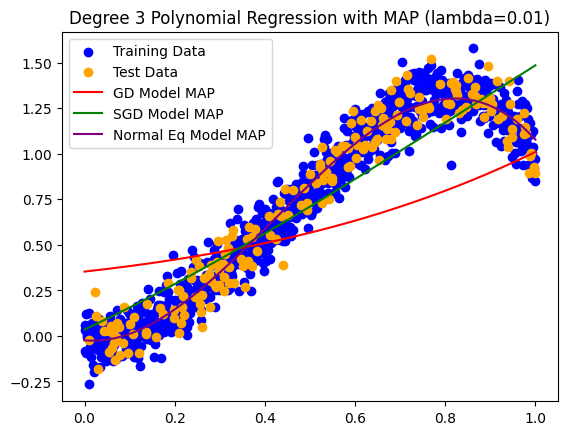

Degree: 3, Lambda: 0.1, GD Error: 0.1378106914106908, SGD Error: 0.06311577993472438, Normal Eq Error: 0.012486945171959904


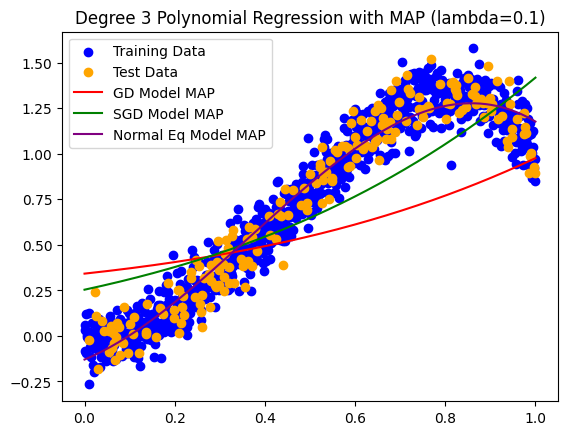

Degree: 4, Lambda: 0.01, GD Error: 0.12008358813989872, SGD Error: 0.029057551348715297, Normal Eq Error: 0.009116063057996376


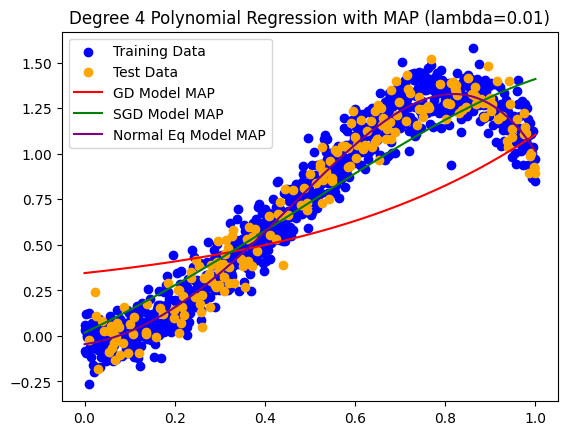

Degree: 4, Lambda: 0.1, GD Error: 0.12837645247112814, SGD Error: 0.06511694628337678, Normal Eq Error: 0.009711621036248293


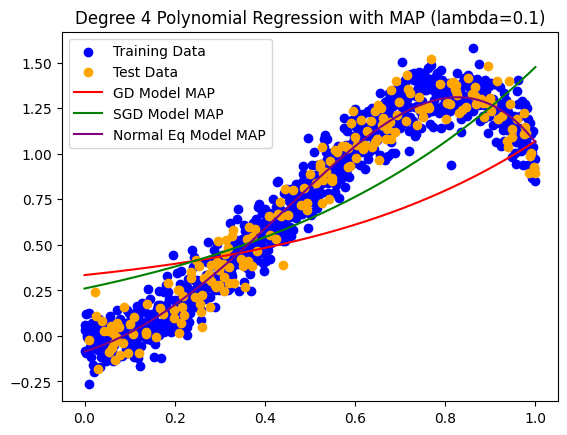

Degree: 5, Lambda: 0.01, GD Error: 0.11649194556360198, SGD Error: 0.023334148132959677, Normal Eq Error: 0.009094022029811832


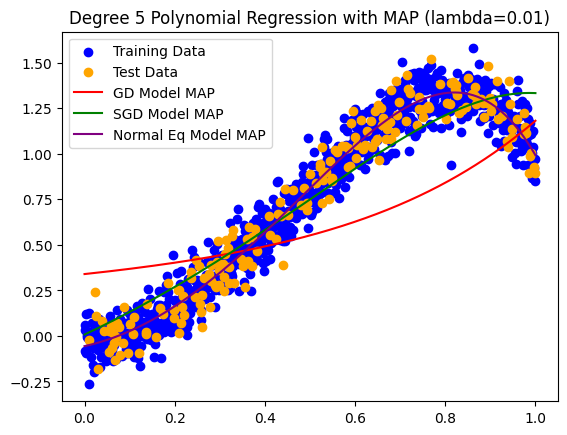

Degree: 5, Lambda: 0.1, GD Error: 0.12432060893738217, SGD Error: 0.06738705072456144, Normal Eq Error: 0.009293816692381334


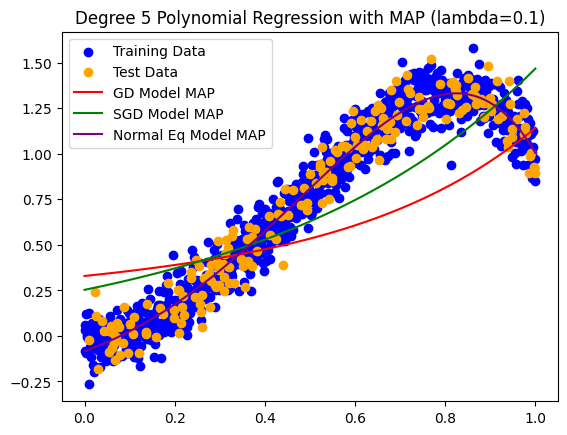

Degree: 6, Lambda: 0.01, GD Error: 0.11542795605240888, SGD Error: 0.0193363741702132, Normal Eq Error: 0.009094302479089982


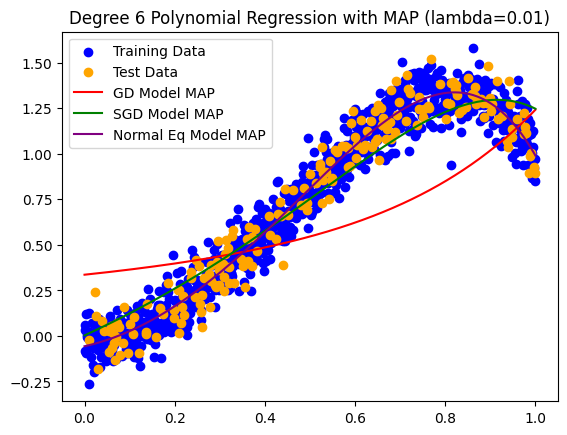

Degree: 6, Lambda: 0.1, GD Error: 0.12287720467430105, SGD Error: 0.0676620642813111, Normal Eq Error: 0.009298287371263514


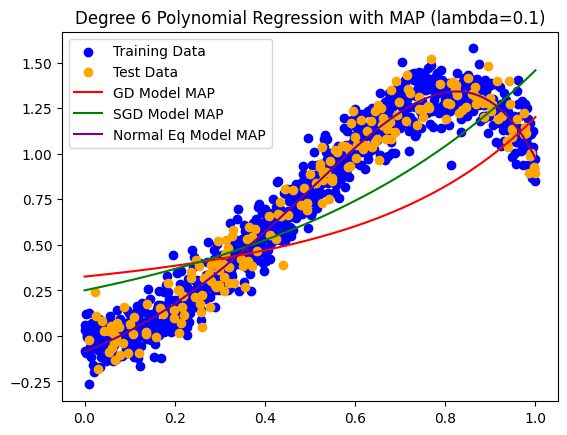

In [8]:

lambdas = [0.01, 0.1]
for degree in range(1, 7):
    for lambda_ in lambdas:
        theta_gd_map, theta_sgd_map, theta_ne_map, results = train_and_evaluate_map(degree, lambda_=lambda_)
        results['Degree'] = degree
        results['Lambda'] = lambda_
        all_results = pd.concat([all_results, results], ignore_index=True)
        print(f"Degree: {degree}, Lambda: {lambda_}, GD Error: {results['Error'][0]}, SGD Error: {results['Error'][1]}, Normal Eq Error: {results['Error'][2]}")
        plot_results_map(degree, theta_gd_map, theta_sgd_map, theta_ne_map, lambda_)

In [9]:
print(all_results)

   Degree                           Method     Error  R-Squared  Lambda
0       1                 Gradient Descent  0.195681   0.171348     NaN
1       1      Stochastic Gradient Descent  0.032757   0.861282     NaN
2       1                 Normal Equations  0.032707   0.861496     NaN
3       2                 Gradient Descent  0.148359   0.371742     NaN
4       2      Stochastic Gradient Descent  0.033871   0.856568     NaN
5       2                 Normal Equations  0.022672   0.903991     NaN
6       3                 Gradient Descent  0.128014   0.457900     NaN
7       3      Stochastic Gradient Descent  0.023899   0.898796     NaN
8       3                 Normal Equations  0.009341   0.960444     NaN
9       4                 Gradient Descent  0.119195   0.495246     NaN
10      4      Stochastic Gradient Descent  0.016157   0.931579     NaN
11      4                 Normal Equations  0.009079   0.961552     NaN
12      5                 Gradient Descent  0.115657   0.510226 

For better vizualisation let's sort it and separe by degrees

In [10]:
df_sorted = all_results.sort_values(by=["Degree", "Lambda"], key=lambda x: x.fillna(-1)).reset_index(drop=True)

/var/folders/nd/0cfyb2fn46s7tqfdlzncgshm0000gp/T/ipykernel_17938/4241326842.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sorted = all_results.sort_values(by=["Degree", "Lambda"], key=lambda x: x.fillna(-1)).reset_index(drop=True)


In [11]:
degree_groups = {}
unique_degrees = df_sorted["Degree"].unique()

# Filter and sort by Lambda for each degree
for degree in unique_degrees:
    degree_data = df_sorted[df_sorted["Degree"] == degree].sort_values(
        by="Lambda", key=lambda x: x.fillna(-1)
    )
    degree_groups[degree] = degree_data

# Display the sorted data for Degree 1 as an example
degree_groups[1]

,Degree,Method,Error,R-Squared,Lambda
0,1,Gradient Descent,0.195681,0.171348,NaN
1,1,Stochastic Gradient Descent,0.032757,0.861282,NaN
2,1,Normal Equations,0.032707,0.861496,NaN
3,1,Gradient Descent MAP,0.196767,0.166749,0.01
4,1,Stochastic Gradient Descent MAP,0.033910,0.856402,0.01
5,1,Normal Equations MAP,0.032705,0.861503,0.01
6,1,Gradient Descent MAP,0.206686,0.124745,0.10
7,1,Stochastic Gradient Descent MAP,0.080388,0.659581,0.10
8,1,Normal Equations MAP,0.032690,0.861568,0.10


In [12]:
degree_groups[2]

,Degree,Method,Error,R-Squared,Lambda
9,2,Gradient Descent,0.148359,0.371742,NaN
10,2,Stochastic Gradient Descent,0.033871,0.856568,NaN
11,2,Normal Equations,0.022672,0.903991,NaN
12,2,Gradient Descent MAP,0.149385,0.367400,0.01
13,2,Stochastic Gradient Descent MAP,0.039436,0.833001,0.01
14,2,Normal Equations MAP,0.022689,0.903918,0.01
15,2,Gradient Descent MAP,0.158827,0.327417,0.10
16,2,Stochastic Gradient Descent MAP,0.061633,0.739001,0.10
17,2,Normal Equations MAP,0.022873,0.903138,0.10


In [13]:
degree_groups[3]

,Degree,Method,Error,R-Squared,Lambda
18,3,Gradient Descent,0.128014,0.457900,NaN
19,3,Stochastic Gradient Descent,0.023899,0.898796,NaN
20,3,Normal Equations,0.009341,0.960444,NaN
21,3,Gradient Descent MAP,0.128967,0.453862,0.01
22,3,Stochastic Gradient Descent MAP,0.035847,0.848198,0.01
23,3,Normal Equations MAP,0.009578,0.959441,0.01
24,3,Gradient Descent MAP,0.137811,0.416413,0.10
25,3,Stochastic Gradient Descent MAP,0.063116,0.732723,0.10
26,3,Normal Equations MAP,0.012487,0.947121,0.10


In [14]:
degree_groups[4]

,Degree,Method,Error,R-Squared,Lambda
27,4,Gradient Descent,0.119195,0.495246,NaN
28,4,Stochastic Gradient Descent,0.016157,0.931579,NaN
29,4,Normal Equations,0.009079,0.961552,NaN
30,4,Gradient Descent MAP,0.120084,0.491482,0.01
31,4,Stochastic Gradient Descent MAP,0.029058,0.876950,0.01
32,4,Normal Equations MAP,0.009116,0.961396,0.01
33,4,Gradient Descent MAP,0.128376,0.456364,0.10
34,4,Stochastic Gradient Descent MAP,0.065117,0.724249,0.10
35,4,Normal Equations MAP,0.009712,0.958874,0.10


In [15]:
degree_groups[5]

,Degree,Method,Error,R-Squared,Lambda
36,5,Gradient Descent,0.115657,0.510226,NaN
37,5,Stochastic Gradient Descent,0.012207,0.948307,NaN
38,5,Normal Equations,0.009032,0.961753,NaN
39,5,Gradient Descent MAP,0.116492,0.506691,0.01
40,5,Stochastic Gradient Descent MAP,0.023334,0.901187,0.01
41,5,Normal Equations MAP,0.009094,0.961490,0.01
42,5,Gradient Descent MAP,0.124321,0.473539,0.10
43,5,Stochastic Gradient Descent MAP,0.067387,0.714636,0.10
44,5,Normal Equations MAP,0.009294,0.960643,0.10


In [16]:
degree_groups[6]

,Degree,Method,Error,R-Squared,Lambda
45,6,Gradient Descent,0.114637,0.514546,NaN
46,6,Stochastic Gradient Descent,0.010508,0.955502,NaN
47,6,Normal Equations,0.009086,0.961524,NaN
48,6,Gradient Descent MAP,0.115428,0.511197,0.01
49,6,Stochastic Gradient Descent MAP,0.019336,0.918116,0.01
50,6,Normal Equations MAP,0.009094,0.961488,0.01
51,6,Gradient Descent MAP,0.122877,0.479652,0.10
52,6,Stochastic Gradient Descent MAP,0.067662,0.713471,0.10
53,6,Normal Equations MAP,0.009298,0.960625,0.10
